In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2025-12-04 01:01:31.655819: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-04 01:01:31.664184: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764831691.674000    6375 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764831691.677057    6375 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764831691.684625    6375 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
SEQUENCE_LENGTH = 24 * 2
STEP_SIZE = 24
FORECAST_HORIZON = 1
BATCH_SIZE = 32
NUM_EPOCHS = 10
SELECT_MODEL = 0

In [3]:
# Load preprocessed feature data
X_train_feature = np.load(f"./data/finalized/X_train_feature_{SELECT_MODEL}.npy")
Y_train_feature = np.load(f"./data/finalized/Y_train_feature_{SELECT_MODEL}.npy")
X_val_feature = np.load(f"./data/finalized/X_val_feature_{SELECT_MODEL}.npy")
Y_val_feature = np.load(f"./data/finalized/Y_val_feature_{SELECT_MODEL}.npy")
X_test_feature = np.load(f"./data/finalized/X_test_feature_{SELECT_MODEL}.npy")
Y_test_feature = np.load(f"./data/finalized/Y_test_feature_{SELECT_MODEL}.npy")

In [4]:
def create_cnn_model(seq_length, forecast_horizon):
    """
    Simple 1D CNN for time-series regression built with TensorFlow/Keras.
    Architecture: Conv1D -> MaxPool -> Dense -> Output
    """
    model = models.Sequential([
        layers.Input(shape=(seq_length, 1)),
        layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='valid'),
        layers.Dropout(0.25),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(50, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(forecast_horizon)
    ])
    
    return model

In [5]:
def evaluate_model(model, X_test, Y_test):
    """Run predictions"""
    y_pred = model.predict(X_test, verbose=0)
    y_true = Y_test
    
    return y_true, y_pred

def print_metrics(y_true, y_pred, model_name="Model"):
    """Print regression metrics"""
    # Calculate metrics
    mse = mean_squared_error(y_true.flatten(), y_pred.flatten())
    mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true.flatten(), y_pred.flatten())
    
    print(f"\n{model_name} Regression Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    return y_true, y_pred, mse, mae, rmse, r2

def evaluate_and_print_metrics(model, X_test, Y_test, model_name="Model"):
    y_true, y_pred = evaluate_model(model, X_test, Y_test)
    return print_metrics(y_true, y_pred, model_name)

In [6]:
# Build the TensorFlow/Keras CNN model
model = create_cnn_model(X_train_feature.shape[1], FORECAST_HORIZON)

# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model.summary()
print("\nModel Architecture:")

2025-12-04 01:01:33.403138: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 44, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 44, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 22, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        70,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,885 (276.89 KB)

 Trainable params: 70,885 (276.89 KB)

 Non-trainable params: 0 (0.00 B)


Model Architecture:


In [7]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
callbacks = [early_stopping, reduce_lr]

# Train the model
history = model.fit(
    X_train_feature,
    Y_train_feature,
    validation_data=(X_val_feature, Y_val_feature),
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0362 - mae: 0.1469 - val_loss: 0.0457 - val_mae: 0.1690 - learning_rate: 0.0010
Epoch 2/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0362 - mae: 0.1469 - val_loss: 0.0457 - val_mae: 0.1690 - learning_rate: 0.0010
Epoch 2/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0326 - mae: 0.1410 - val_loss: 0.0298 - val_mae: 0.1319 - learning_rate: 0.0010
Epoch 3/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0326 - mae: 0.1410 - val_loss: 0.0298 - val_mae: 0.1319 - learning_rate: 0.0010
Epoch 3/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0315 - mae: 0.1380 - val_loss: 0.0268 - val_mae: 0.1257 - learning_rate: 0.0010
Epoch 4/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0315 - mae: 0.1380 - val_loss: 0.0268 - val_mae: 0.1257 - learning_rate: 0.0010
Epoch 4/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0299 - mae: 0.1359 - val_loss: 0.0340 - val_mae: 0.1435 - learning_rate: 0.0010
Epoch 

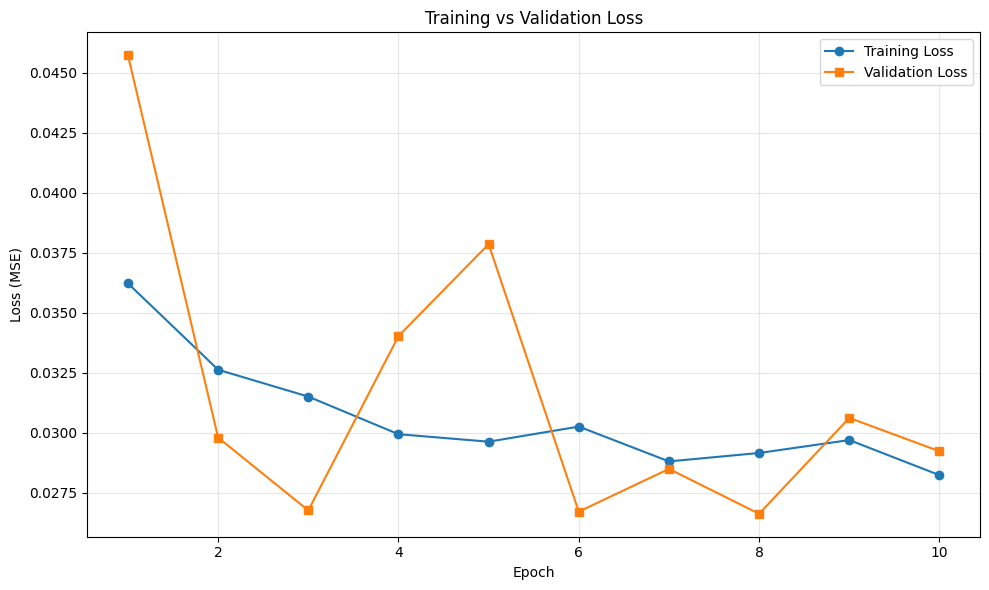


Final Training Loss: 0.0282
Final Validation Loss: 0.0292
Difference (Val - Train): 0.0010
Ratio (Val / Train): 1.04


In [8]:
# Plot training and validation loss
import matplotlib.pyplot as plt

train_losses = history.history['loss']
val_losses = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Check for overfitting
final_train_loss = train_losses[-1]
final_val_loss = val_losses[-1]
loss_diff = final_val_loss - final_train_loss
loss_ratio = final_val_loss / final_train_loss

print(f"\nFinal Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

print(f"Difference (Val - Train): {loss_diff:.4f}")
print(f"Ratio (Val / Train): {loss_ratio:.2f}")

In [9]:
# Evaluate the model
print("\n--- Evaluating Model Performance ---")
y_true, y_pred, mse, mae, rmse, r2 = evaluate_and_print_metrics(model, X_test_feature, Y_test_feature)


--- Evaluating Model Performance ---

Model Regression Metrics:
Mean Squared Error (MSE): 0.0261
Root Mean Squared Error (RMSE): 0.1617
Mean Absolute Error (MAE): 0.1281
R² Score: 0.8819

Model Regression Metrics:
Mean Squared Error (MSE): 0.0261
Root Mean Squared Error (RMSE): 0.1617
Mean Absolute Error (MAE): 0.1281
R² Score: 0.8819


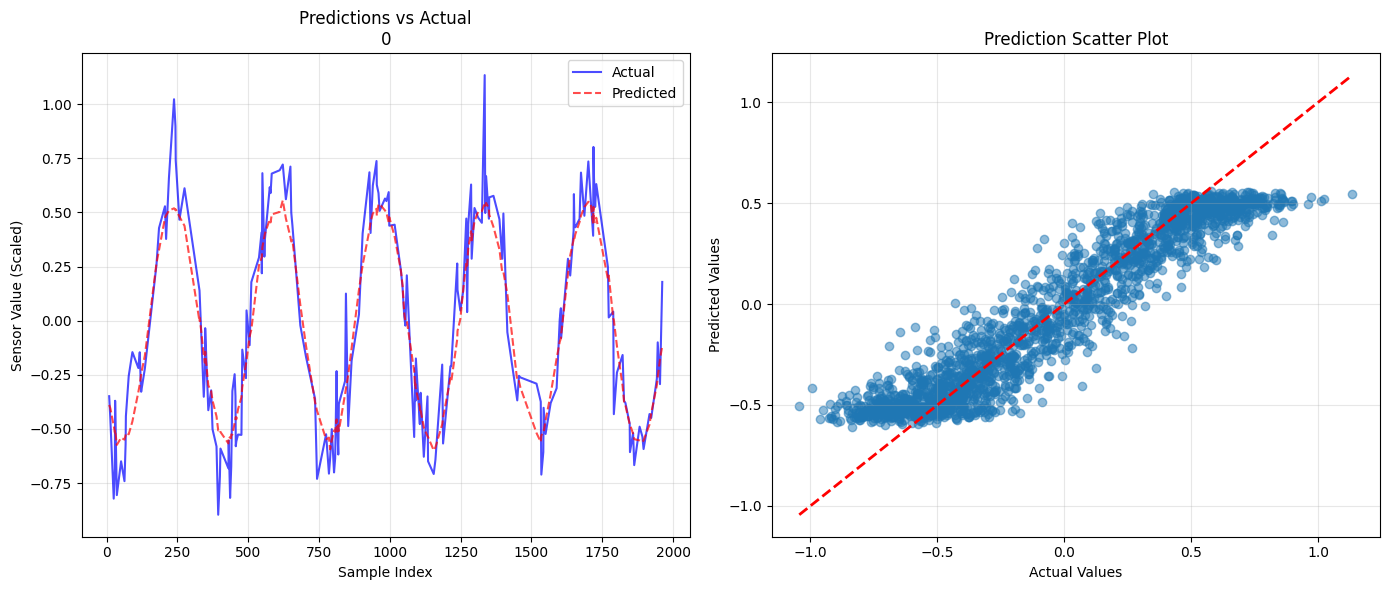

In [10]:
y_true_flat = np.array(y_true).reshape(-1)
y_pred_flat = np.array(y_pred).reshape(-1)

plt.figure(figsize=(14, 6))

# Sample a subset for visualization if too many points
num_samples = min(200, len(y_true_flat))
if num_samples == 0:
    print("No test samples available to plot.")
else:
    indices = np.random.choice(len(y_true_flat), num_samples, replace=False)
    indices = np.sort(indices)

    plt.subplot(1, 2, 1)
    plt.plot(indices, y_true_flat[indices], 'b-', label='Actual', alpha=0.7)
    plt.plot(indices, y_pred_flat[indices], 'r--', label='Predicted', alpha=0.7)
    plt.xlabel('Sample Index')
    plt.ylabel('Sensor Value (Scaled)')
    plt.title(f'Predictions vs Actual\n{SELECT_MODEL}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.scatter(y_true_flat, y_pred_flat, alpha=0.5)
    mn = min(y_true_flat.min(), y_pred_flat.min())
    mx = max(y_true_flat.max(), y_pred_flat.max())
    plt.plot([mn, mx], [mn, mx], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Prediction Scatter Plot')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Pruning the Model

In [11]:
import tf2onnx
from onnxruntime.quantization import quantize_dynamic, QuantType
import tempfile
import os

In [12]:
def structured_prune_model(model, target_prune_ratio=0.5):
    """
    Structured pruning for TensorFlow/Keras models.
    Removes entire filters/channels based on their L2 norm.
    
    Args:
        model: Trained Keras model to prune
        target_prune_ratio: Fraction of filters to prune (0.5 = 50%)
    
    Returns:
        New pruned model with reduced filters/channels
    """
    print("\n=== Structured Pruning (Filter-level) ===")
    
    # Get original architecture info
    original_filters = []
    for layer in model.layers:
        if isinstance(layer, layers.Conv1D):
            original_filters.append(layer.filters)
        elif isinstance(layer, layers.Dense) and hasattr(layer, 'units'):
            original_filters.append(layer.units)
    
    print(f"Original architecture filters: {original_filters}")
    
    # Build a new pruned model with reduced filters
    pruned_layers = []
    filter_masks = {}  # Store which filters to keep for each layer
    
    for i, layer in enumerate(model.layers):
        if isinstance(layer, layers.Conv1D):
            # Calculate L2 norm for each filter
            weights = layer.get_weights()[0]  # Shape: (kernel_size, in_channels, out_channels)
            num_filters = weights.shape[-1]
            
            # Compute L2 norm for each filter (across kernel and input dimensions)
            filter_norms = np.linalg.norm(weights.reshape(-1, num_filters), axis=0)
            
            # Determine how many filters to keep
            num_keep = max(1, int(num_filters * (1 - target_prune_ratio)))
            
            # Get indices of filters with highest L2 norms
            keep_indices = np.argsort(filter_norms)[-num_keep:]
            keep_indices = np.sort(keep_indices)  # Keep order
            filter_masks[layer.name] = keep_indices
            
            print(f"Layer '{layer.name}': Keeping {num_keep}/{num_filters} filters ({(1-num_keep/num_filters)*100:.1f}% pruned)")
            
        elif isinstance(layer, layers.Dense) and len(layer.get_weights()) > 0:
            # For Dense layers, prune neurons based on L2 norm
            weights = layer.get_weights()[0]  # Shape: (input_dim, units)
            num_units = weights.shape[-1]
            
            # Compute L2 norm for each neuron
            neuron_norms = np.linalg.norm(weights, axis=0)
            
            # Determine how many neurons to keep
            num_keep = max(1, int(num_units * (1 - target_prune_ratio)))
            
            # Get indices of neurons with highest L2 norms
            keep_indices = np.argsort(neuron_norms)[-num_keep:]
            keep_indices = np.sort(keep_indices)
            filter_masks[layer.name] = keep_indices
            
            print(f"Layer '{layer.name}': Keeping {num_keep}/{num_units} neurons ({(1-num_keep/num_units)*100:.1f}% pruned)")
    
    # Rebuild model with pruned architecture
    print("\n=== Building Pruned Model ===")
    
    # Get layer configurations
    conv1d_layer = None
    dense_layer = None
    
    for layer in model.layers:
        if isinstance(layer, layers.Conv1D):
            conv1d_layer = layer
        elif isinstance(layer, layers.Dense) and layer.name in filter_masks:
            dense_layer = layer
            break
    
    # Create new model with reduced filters
    if conv1d_layer and conv1d_layer.name in filter_masks:
        num_conv_filters = len(filter_masks[conv1d_layer.name])
    else:
        num_conv_filters = 64  # Default
    
    if dense_layer and dense_layer.name in filter_masks:
        num_dense_units = len(filter_masks[dense_layer.name])
    else:
        num_dense_units = 50  # Default
    
    seq_length = model.input_shape[1]
    forecast_horizon = model.output_shape[1]
    
    pruned_model = models.Sequential([
        layers.Input(shape=(seq_length, 1)),
        layers.Conv1D(filters=num_conv_filters, kernel_size=5, activation='relu', padding='valid'),
        layers.Dropout(0.25),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(num_dense_units, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(forecast_horizon)
    ])
    
    print(f"\nPruned architecture: Conv1D({num_conv_filters}) -> Dense({num_dense_units}) -> Dense({forecast_horizon})")
    
    # Transfer pruned weights
    conv_keep_indices = None
    dense_count = 0
    
    for old_layer, new_layer in zip(model.layers, pruned_model.layers):
        if old_layer.name in filter_masks and len(old_layer.get_weights()) > 0:
            old_weights = old_layer.get_weights()
            keep_indices = filter_masks[old_layer.name]
            
            if isinstance(old_layer, layers.Conv1D):
                # Prune output filters from Conv1D
                pruned_kernel = old_weights[0][:, :, keep_indices]
                pruned_bias = old_weights[1][keep_indices]
                new_layer.set_weights([pruned_kernel, pruned_bias])
                conv_keep_indices = keep_indices
                print(f"Transferred Conv1D weights: {pruned_kernel.shape}")
                
            elif isinstance(old_layer, layers.Dense):
                # Handle Dense layer pruning
                if dense_count == 0:
                    # First Dense layer after Flatten - need to handle Conv1D output changes
                    # The input dimension changes because we pruned Conv1D filters
                    
                    # Calculate the flattened size after conv, pool, etc.
                    # For this architecture: Conv1D -> MaxPool -> Flatten
                    # Original: (seq_len - 4) / 2 * num_conv_filters
                    # Pruned: (seq_len - 4) / 2 * num_pruned_conv_filters
                    
                    old_input_dim = old_weights[0].shape[0]
                    old_output_dim = old_weights[0].shape[1]
                    
                    # Reshape to separate the flattened conv output structure
                    # old_weights[0] shape: (old_flattened_size, old_units)
                    # We need to prune based on which conv filters were kept
                    
                    if conv_keep_indices is not None:
                        # Calculate old and new flatten sizes
                        old_conv_filters = 64
                        new_conv_filters = len(conv_keep_indices)
                        
                        # After conv (kernel=5, padding=valid): seq_len - 4
                        # After maxpool (pool=2): (seq_len - 4) // 2
                        seq_after_pool = (model.input_shape[1] - 4) // 2
                        
                        old_flatten_size = seq_after_pool * old_conv_filters
                        new_flatten_size = seq_after_pool * new_conv_filters
                        
                        # Reshape old weights to (seq_after_pool, old_conv_filters, old_units)
                        old_kernel_reshaped = old_weights[0].reshape(seq_after_pool, old_conv_filters, old_output_dim)
                        
                        # Select only the kept conv filters
                        pruned_kernel_reshaped = old_kernel_reshaped[:, conv_keep_indices, :]
                        
                        # Now prune the output neurons
                        pruned_kernel_reshaped = pruned_kernel_reshaped[:, :, keep_indices]
                        
                        # Flatten back
                        pruned_kernel = pruned_kernel_reshaped.reshape(new_flatten_size, len(keep_indices))
                        pruned_bias = old_weights[1][keep_indices]
                        
                        new_layer.set_weights([pruned_kernel, pruned_bias])
                        print(f"Transferred 1st Dense weights: {pruned_kernel.shape}")
                    else:
                        # No conv pruning, just prune output
                        pruned_kernel = old_weights[0][:, keep_indices]
                        pruned_bias = old_weights[1][keep_indices]
                        new_layer.set_weights([pruned_kernel, pruned_bias])
                        print(f"Transferred 1st Dense weights (no conv pruning): {pruned_kernel.shape}")
                else:
                    # Subsequent Dense layers - prune both input and output
                    # Need to get the previous Dense layer's keep indices
                    prev_dense_layer = None
                    for prev_layer in reversed(model.layers[:model.layers.index(old_layer)]):
                        if isinstance(prev_layer, layers.Dense):
                            prev_dense_layer = prev_layer
                            break
                    
                    if prev_dense_layer and prev_dense_layer.name in filter_masks:
                        prev_keep_indices = filter_masks[prev_dense_layer.name]
                        pruned_kernel = old_weights[0][prev_keep_indices, :][:, keep_indices]
                        pruned_bias = old_weights[1][keep_indices]
                    else:
                        pruned_kernel = old_weights[0][:, keep_indices]
                        pruned_bias = old_weights[1][keep_indices]
                    
                    new_layer.set_weights([pruned_kernel, pruned_bias])
                    print(f"Transferred Dense weights: {pruned_kernel.shape}")
                
                dense_count += 1
        elif len(old_layer.get_weights()) > 0 and not isinstance(old_layer, (layers.Dropout, layers.MaxPooling1D, layers.Flatten)):
            # Transfer weights for unpruned layers (like the final output Dense)
            if isinstance(old_layer, layers.Dense):
                # This is likely the output layer - need to adjust input from pruned previous layer
                old_weights = old_layer.get_weights()
                
                # Find previous Dense layer
                prev_dense_layer = None
                for prev_layer in reversed(model.layers[:model.layers.index(old_layer)]):
                    if isinstance(prev_layer, layers.Dense):
                        prev_dense_layer = prev_layer
                        break
                
                if prev_dense_layer and prev_dense_layer.name in filter_masks:
                    prev_keep_indices = filter_masks[prev_dense_layer.name]
                    pruned_kernel = old_weights[0][prev_keep_indices, :]
                    pruned_bias = old_weights[1]
                    new_layer.set_weights([pruned_kernel, pruned_bias])
                    print(f"Transferred output Dense weights: {pruned_kernel.shape}")
                else:
                    new_layer.set_weights(old_layer.get_weights())
            else:
                new_layer.set_weights(old_layer.get_weights())
    
    # Calculate total parameter reduction
    original_params = model.count_params()
    pruned_params = pruned_model.count_params()
    reduction = (1 - pruned_params / original_params) * 100
    
    print(f"\n=== Parameter Reduction ===")
    print(f"Original parameters: {original_params:,}")
    print(f"Pruned parameters: {pruned_params:,}")
    print(f"Reduction: {reduction:.1f}%")
    
    return pruned_model

# Apply structured pruning to your trained model
pruned_model = structured_prune_model(model, target_prune_ratio=0.5)

# Compile the pruned model
pruned_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)


=== Structured Pruning (Filter-level) ===
Original architecture filters: [64, 50, 1]
Layer 'conv1d': Keeping 32/64 filters (50.0% pruned)
Layer 'dense': Keeping 25/50 neurons (50.0% pruned)
Layer 'dense_1': Keeping 1/1 neurons (0.0% pruned)

=== Building Pruned Model ===

Pruned architecture: Conv1D(32) -> Dense(25) -> Dense(1)
Transferred Conv1D weights: (5, 1, 32)
Transferred 1st Dense weights: (704, 25)
Transferred Dense weights: (25, 1)

=== Parameter Reduction ===
Original parameters: 70,885
Pruned parameters: 17,843
Reduction: 74.8%


In [13]:
# Fine-tune the pruned model to recover accuracy
print("\n=== Fine-tuning Pruned Model ===")
print("Training for 5 epochs to recover from pruning...\n")

# Use lower learning rate for fine-tuning
pruned_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower LR for fine-tuning
    loss='mse',
    metrics=['mae']
)

# Define callbacks
callbacks_pruned = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)
]

# Fine-tune
history_pruned = pruned_model.fit(
    X_train_feature,
    Y_train_feature,
    validation_data=(X_val_feature, Y_val_feature),
    epochs=5,  # Just a few epochs to recover
    batch_size=BATCH_SIZE,
    callbacks=callbacks_pruned,
    verbose=1
)


=== Fine-tuning Pruned Model ===
Training for 5 epochs to recover from pruning...

Epoch 1/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0396 - mae: 0.1560 - val_loss: 0.0307 - val_mae: 0.1353 - learning_rate: 1.0000e-04
Epoch 2/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0396 - mae: 0.1560 - val_loss: 0.0307 - val_mae: 0.1353 - learning_rate: 1.0000e-04
Epoch 2/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0303 - mae: 0.1369 - val_loss: 0.0308 - val_mae: 0.1353 - learning_rate: 1.0000e-04
Epoch 3/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0303 - mae: 0.1369 - val_loss: 0.0308 - val_mae: 0.1353 - learning_rate: 1.0000e-04
Epoch 3/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0300 - mae: 0.1367 - val_loss: 0.0299 - val_mae: 0.1336 - learning_rate: 1.0000e-04
Epoch 4/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0300 - mae: 0.1367 - val_loss: 0.0299 - val_mae: 0.1336 - learning_rate: 1.0000e-04
Epoch 4/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

In [14]:
def check_model_sparsity(model):
    """Calculate actual sparsity of the model after pruning"""
    total_weights = 0
    zero_weights = 0
    
    for layer in model.layers:
        if hasattr(layer, 'kernel'):
            weights = layer.get_weights()[0]
            total_weights += weights.size
            zero_weights += np.sum(weights == 0)
    
    sparsity_pct = (zero_weights / total_weights) * 100
    return sparsity_pct, total_weights, zero_weights

# Evaluate the pruned model
print("\n=== Evaluating Pruned Model Performance ===")
y_true_pruned, y_pred_pruned, mse_pruned, mae_pruned, rmse_pruned, r2_pruned = evaluate_and_print_metrics(
    pruned_model, X_test_feature, Y_test_feature, "Pruned Model"
)

# Verify sparsity
sparsity, total, zeros = check_model_sparsity(pruned_model)
print(f"\nVerified Sparsity: {sparsity:.2f}% ({zeros:,} / {total:,} weights are zero)")
final_pruned_model = pruned_model


=== Evaluating Pruned Model Performance ===

Pruned Model Regression Metrics:
Mean Squared Error (MSE): 0.0298
Root Mean Squared Error (RMSE): 0.1725
Mean Absolute Error (MAE): 0.1368
R² Score: 0.8656

Verified Sparsity: 0.00% (0 / 17,785 weights are zero)

Pruned Model Regression Metrics:
Mean Squared Error (MSE): 0.0298
Root Mean Squared Error (RMSE): 0.1725
Mean Absolute Error (MAE): 0.1368
R² Score: 0.8656

Verified Sparsity: 0.00% (0 / 17,785 weights are zero)


In [15]:
# Save the pruned model temporarily for quantization
_, temp_model_path = tempfile.mkstemp(suffix='.h5', dir='./model')
final_pruned_model.save(temp_model_path)
print(f"Pruned model saved temporarily at: {temp_model_path}")

Pruned model saved temporarily at: /home/redninjale/AFTAC-DL/soh-model/model/tmpho1hwq16.h5


# Dynamic Quantization

In [16]:
### Tensorflow Lite Quantization
# Create a representative dataset generator for quantization
def representative_dataset_gen():
    """
    Generator function to provide representative samples for quantization.
    Uses a subset of training data.
    """
    num_calibration_samples = min(2000, len(X_train_feature))
    for i in range(num_calibration_samples):
        # Yield a single sample with correct shape for the model
        yield [X_train_feature[i:i+1].astype(np.float32)]

print("\nRepresentative dataset generator created for quantization.")

# Convert the pruned model to TensorFlow Lite with 8-bit integer quantization
converter = tf.lite.TFLiteConverter.from_keras_model(final_pruned_model)

# Set optimization flags for full integer quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen

print("\nTrying with dynamic range quantization instead...")
# Fallback to dynamic range quantization
converter = tf.lite.TFLiteConverter.from_keras_model(final_pruned_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
quantized_tflite_model = converter.convert()
print("Dynamic range quantization successful!")

print(f"\n--- Saving Prune + Quantized Model ---")

# Save tensorflow lite model
quantized_model_path = './model/pruned_quantized_model.tflite'
with open(quantized_model_path, 'wb') as f:
    f.write(quantized_tflite_model)

print(f"Location: {quantized_model_path}")
print(f"Size: {len(quantized_tflite_model) / 1024:.2f} KB")


Representative dataset generator created for quantization.

Trying with dynamic range quantization instead...
INFO:tensorflow:Assets written to: /tmp/tmp8i3ncfa3/assets
INFO:tensorflow:Assets written to: /tmp/tmp8i3ncfa3/assets


INFO:tensorflow:Assets written to: /tmp/tmp8i3ncfa3/assets


Saved artifact at '/tmp/tmp8i3ncfa3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 1), dtype=tf.float32, name='keras_tensor_8')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  129714900176528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129714900176912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129714900177104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129714900175760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129714900178832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129714900177296: TensorSpec(shape=(), dtype=tf.resource, name=None)


/home/redninjale/AFTAC-DL/.venv/lib/python3.12/site-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Dynamic range quantization successful!

--- Saving Prune + Quantized Model ---
Location: ./model/pruned_quantized_model.tflite
Size: 24.06 KB


W0000 00:00:1764831705.584537    6375 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1764831705.584578    6375 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-12-04 01:01:45.584763: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp8i3ncfa3
2025-12-04 01:01:45.585015: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-12-04 01:01:45.585020: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp8i3ncfa3
I0000 00:00:1764831705.588121    6375 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-12-04 01:01:45.588567: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-12-04 01:01:45.604141: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp8i3ncfa3
2025-12-04 01:01:45.608230: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 

In [17]:
### Onnx Model Quantization
# Temporarily save the pruned model as ONNX
temp_onnx_model_path = "./model/pruned_model.onnx"
spec = (tf.TensorSpec(final_pruned_model.inputs[0].shape, tf.float32, name="input"),)
final_pruned_model.output_names = ["output"]
model_proto, _ = tf2onnx.convert.from_keras(final_pruned_model, input_signature=spec, opset=13)

with open (temp_onnx_model_path, "wb") as f:
    f.write(model_proto.SerializeToString())

# Turn the ONNX model into a quantized version using dynamic quantization
print("\n--- Quantizing ONNX Model ---")
quantized_onnx_path = "./model/pruned_quantized_model.onnx"
quantize_dynamic(
    model_input=temp_onnx_model_path,
    model_output=quantized_onnx_path,
    weight_type=QuantType.QUInt8  # or QInt8
)

print(f"\nDynamic quantization complete!")
print(f"Location: {quantized_onnx_path}")
print(f"Size: {os.path.getsize(quantized_onnx_path) / 1024:.2f} KB")

# Compare sizes
original_onnx_size = os.path.getsize(temp_onnx_model_path)
quantized_onnx_size = os.path.getsize(quantized_onnx_path)
compression_ratio = original_onnx_size / quantized_onnx_size

print(f"\nONNX Model Compression:")
print(f"  Original: {original_onnx_size / 1024:.2f} KB")
print(f"  Quantized: {quantized_onnx_size / 1024:.2f} KB")
print(f"  Compression: {compression_ratio:.2f}x smaller ({(1 - quantized_onnx_size/original_onnx_size)*100:.1f}% reduction)")

os.remove(temp_onnx_model_path)

I0000 00:00:1764831705.811404    6375 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1764831705.811545    6375 single_machine.cc:374] Starting new session
I0000 00:00:1764831705.852928    6375 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1764831705.853065    6375 single_machine.cc:374] Starting new session



--- Quantizing ONNX Model ---

Dynamic quantization complete!
Location: ./model/pruned_quantized_model.onnx
Size: 25.45 KB

ONNX Model Compression:
  Original: 72.97 KB
  Quantized: 25.45 KB
  Compression: 2.87x smaller (65.1% reduction)


In [18]:
# Evaluate the quantized TFLite model
print("\n--- Evaluating Quantized Model ---")

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=quantized_model_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(f"Input details: {input_details[0]['shape']}, dtype: {input_details[0]['dtype']}")
print(f"Output details: {output_details[0]['shape']}, dtype: {output_details[0]['dtype']}")

# Make predictions on test set
quantized_predictions = []

for i in range(len(X_test_feature)):
    # Prepare input
    input_data = X_test_feature[i:i+1].astype(input_details[0]['dtype'])
    
    # If input is int8, we need to quantize
    if input_details[0]['dtype'] == np.int8:
        input_scale, input_zero_point = input_details[0]['quantization']
        input_data = (input_data / input_scale + input_zero_point).astype(np.int8)
    
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    
    # Get output
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    # If output is int8, we need to dequantize
    if output_details[0]['dtype'] == np.int8:
        output_scale, output_zero_point = output_details[0]['quantization']
        output_data = (output_data.astype(np.float32) - output_zero_point) * output_scale
    
    quantized_predictions.append(output_data[0])

quantized_predictions = np.array(quantized_predictions)

# Calculate metrics
y_true_flat_quant = Y_test_feature.flatten()
y_pred_flat_quant = quantized_predictions.flatten()

y_true, y_pred, mse_quantized, mae_quantized, rmse_quantized, r2_quantized = print_metrics(y_true_flat_quant, y_pred_flat_quant, "Quantized Model")


--- Evaluating Quantized Model ---
Input details: [ 1 48  1], dtype: <class 'numpy.float32'>
Output details: [1 1], dtype: <class 'numpy.float32'>

Quantized Model Regression Metrics:
Mean Squared Error (MSE): 0.0298
Root Mean Squared Error (RMSE): 0.1726
Mean Absolute Error (MAE): 0.1368
R² Score: 0.8655


/home/redninjale/AFTAC-DL/.venv/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [19]:
# Compare model sizes
import os

# Get original model size
_, original_model_path = tempfile.mkstemp(suffix='.h5', dir="./model")
print(original_model_path)
model.save(original_model_path)
original_size = os.path.getsize(original_model_path)

# Get pruned model size
pruned_size = os.path.getsize(temp_model_path)

# Get quantized model size
quantized_size = len(quantized_tflite_model)

print("\n=== Model Size Comparison ===")
print(f"Original Model: {original_size / 1024:.2f} KB")
print(f"Pruned Model: {pruned_size / 1024:.2f} KB ({(1 - pruned_size/original_size)*100:.1f}% reduction)")
print(f"Pruned + Quantized Model: {quantized_size / 1024:.2f} KB ({(1 - quantized_size/original_size)*100:.1f}% reduction)")
print(f"\nTotal compression: {original_size / quantized_size:.2f}x smaller")

print("\n=== Final Model Comparison ===")
print(f"{'Model':<25} {'MSE':<10} {'MAE':<10} {'R²':<10}")
print(f"{'-'*55}")
print(f"{'Original':<25} {mse:<10.4f} {mae:<10.4f} {r2:<10.4f}")
print(f"{'Pruned':<25} {mse_pruned:<10.4f} {mae_pruned:<10.4f} {r2_pruned:<10.4f}")
print(f"{'Pruned + Quantized':<25} {mse_quantized:<10.4f} {mae_quantized:<10.4f} {r2_quantized:<10.4f}")

# Cleanup temporary files
os.remove(original_model_path)
os.remove(temp_model_path)

/home/redninjale/AFTAC-DL/soh-model/model/tmpf9zpa0nn.h5

=== Model Size Comparison ===
Original Model: 866.07 KB
Pruned Model: 243.82 KB (71.8% reduction)
Pruned + Quantized Model: 24.06 KB (97.2% reduction)

Total compression: 35.99x smaller

=== Final Model Comparison ===
Model                     MSE        MAE        R²        
-------------------------------------------------------
Original                  0.0261     0.1281     0.8819    
Pruned                    0.0298     0.1368     0.8656    
Pruned + Quantized        0.0298     0.1368     0.8655    

=== Model Size Comparison ===
Original Model: 866.07 KB
Pruned Model: 243.82 KB (71.8% reduction)
Pruned + Quantized Model: 24.06 KB (97.2% reduction)

Total compression: 35.99x smaller

=== Final Model Comparison ===
Model                     MSE        MAE        R²        
-------------------------------------------------------
Original                  0.0261     0.1281     0.8819    
Pruned                    0.0298     0.

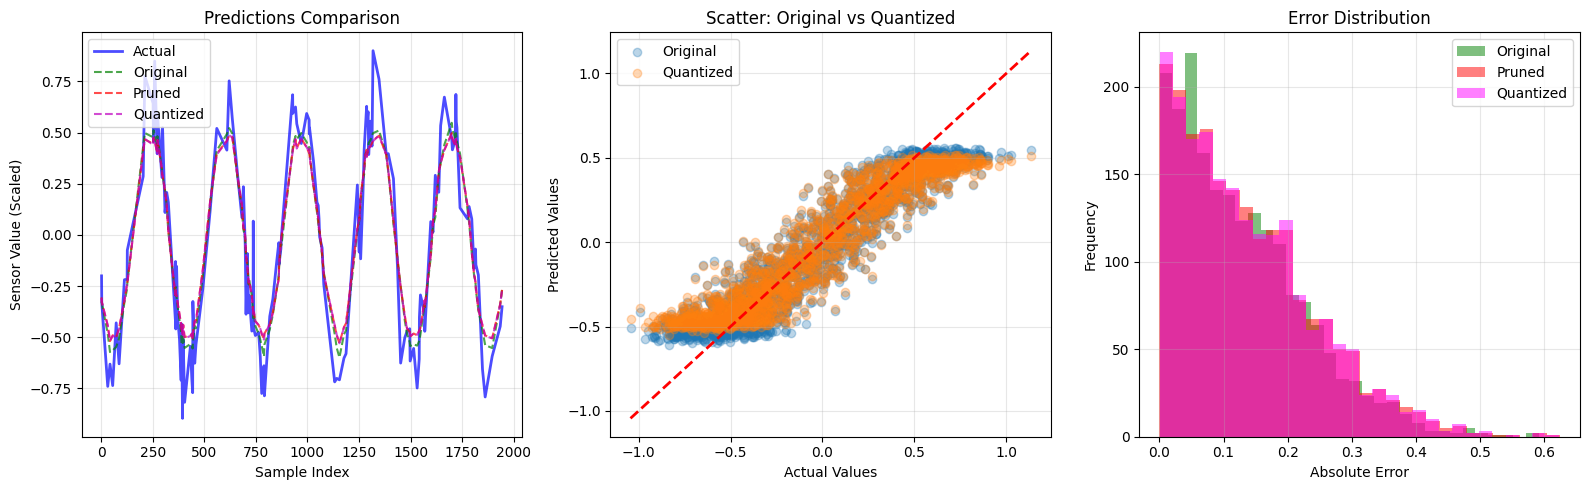

In [20]:
# Visualize predictions comparison
plt.figure(figsize=(16, 5))

num_samples = min(150, len(y_true_flat))
if num_samples > 0:
    indices = np.random.choice(len(y_true_flat), num_samples, replace=False)
    indices = np.sort(indices)

    # Plot 1: Time series comparison
    plt.subplot(1, 3, 1)
    plt.plot(indices, y_true_flat[indices], 'b-', label='Actual', alpha=0.7, linewidth=2)
    plt.plot(indices, y_pred_flat[indices], 'g--', label='Original', alpha=0.7)
    plt.plot(indices, y_pred_pruned.flatten()[indices], 'r--', label='Pruned', alpha=0.7)
    plt.plot(indices, y_pred_flat_quant[indices], 'm--', label='Quantized', alpha=0.7)
    plt.xlabel('Sample Index')
    plt.ylabel('Sensor Value (Scaled)')
    plt.title('Predictions Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Original vs Quantized scatter
    plt.subplot(1, 3, 2)
    plt.scatter(y_true_flat, y_pred_flat, alpha=0.3, label='Original')
    plt.scatter(y_true_flat, y_pred_flat_quant, alpha=0.3, label='Quantized')
    mn = min(y_true_flat.min(), y_pred_flat.min(), y_pred_flat_quant.min())
    mx = max(y_true_flat.max(), y_pred_flat.max(), y_pred_flat_quant.max())
    plt.plot([mn, mx], [mn, mx], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Scatter: Original vs Quantized')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 3: Error distribution
    plt.subplot(1, 3, 3)
    error_original = np.abs(y_true_flat - y_pred_flat)
    error_pruned = np.abs(y_true_flat - y_pred_pruned.flatten())
    error_quantized = np.abs(y_true_flat - y_pred_flat_quant)
    
    plt.hist(error_original, bins=30, alpha=0.5, label='Original', color='green')
    plt.hist(error_pruned, bins=30, alpha=0.5, label='Pruned', color='red')
    plt.hist(error_quantized, bins=30, alpha=0.5, label='Quantized', color='magenta')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.title('Error Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("No test samples available to plot.")